In [1]:
# supply location of the log file to analyze

log_file="/Users/gwilliams/Projects/GSI/IPMI/data/tests/2021-06-02_22:08:52"

In [2]:
# parse the log file into a dataframe

from datetime import datetime
import copy

f = open(log_file)
lines = f.readlines()
f.close()

c=0
if not lines[c].startswith("IpmiLogger"):
    raise Exception("Invalid log file")
c += 1

sensors = {}
while True:
    #print(lines[c])
    if lines[c].find("SENSOR")>0:
        sensor_description = lines[c].split("--")[1]
        record_id = lines[c].split()[-2]
        sensors[record_id] = {'description':sensor_description}
        c += 1
    else:
        break
num_sensors = len(sensors.keys())
if num_sensors==0:
    raise Exception("No sensors found in header.")
    
tests = []
cur_test = None
test = None
capture = False
while c < len(lines):
    el = lines[c].split("--")[1].split()[0]
    if el=="cpu":
        cur_test = lines[c].split("--")[1].split()[-1]
        test = {'cpu':int(cur_test), 'data':dict(zip( list(sensors.keys()),[[] for i in range(len(sensors.keys()))] ) ) }
        #print("current test=",cur_test)
    elif el=="stress":
        on_off = lines[c].split("--")[1].split()[-1].strip()
        if on_off == "1":
            capture = True
        elif on_off == "0":
            if test: tests.append(test)
            capture = False
            #break
        else:
            raise Exception("Invalid value for stress")
    elif test and capture and el in test['data'].keys():
        dt = lines[c].split("--")[0].strip()
        #print("-%s-" % dt)
        dto = datetime.strptime(dt, '%Y-%m-%d_%H:%M:%S')
        val = float(lines[c].split("--")[1].split()[-1])
        #print(dt,val)
        test['data'][el].append( [ dto, val] )
        #print("adding", test['cpu'], el, val, len(test['data'][el]))
        #print(len( test['data']['18']))
        #print(len( test['data']['20']))
        #print(cur_test,el,dto,val)
    c += 1
    
#print(len( tests[0]['data']['18']))
#print(tests[0]['data']['18'])
#print(len( tests[1]['data']['20']))
    
ready_for_df = []
for test in tests:
    #print(test['cpu'])
    keys = test['data'].keys()
    for record_id in keys:
        #print(test['data'].keys(), test['cpu'], record_id, len(test['data'][record_id]))
        #print(record_id, len(test['data'][record_id]) )#, test['data'][record_id][0][0],test['data'][record_id][0][1])
        for idx, data_point in enumerate( test['data'][record_id] ):
            df_item = [ test['cpu'], int(record_id), data_point[0], data_point[1] ]  
            #print(df_item)
            ready_for_df.append(df_item)

import pandas as pd 
df = pd.DataFrame(ready_for_df, columns =['cpu','record_id','data','value'])
df

,cpu,record_id,data,value
0,1,18,2021-06-02 22:09:17,176.0
1,1,18,2021-06-02 22:09:18,176.0
2,1,18,2021-06-02 22:09:19,176.0
3,1,18,2021-06-02 22:09:20,176.0
4,1,18,2021-06-02 22:09:21,176.0
...,...,...,...,...
3004,56,20,2021-06-02 22:46:25,256.0
3005,56,20,2021-06-02 22:46:26,256.0
3006,56,20,2021-06-02 22:46:27,256.0
3007,56,20,2021-06-02 22:46:28,256.0


In [21]:
all_data = []
record_ids = [ int(record_id) for record_id in sensors.keys() ]

for stress_test in range(1,57):
    
    emt = [None for r in record_ids]
    dct = dict(zip( record_ids, emt ))
    data = {'cpu':stress_test, 'data':dct }
    
    for record_id in record_ids:
        
        cpu = df.loc[df['cpu']==stress_test]
        cpu_and_record = cpu.loc[ cpu['record_id'] == record_id ]
      
        ts = cpu_and_record[['data','value']].values.tolist()
        dt, val = zip(*ts)
        cdt = [ (t-dt[0]).total_seconds() for t in dt ]
        data['data'][record_id] =[ cdt, val ]
    all_data.append(data)
print(len(all_data))

56


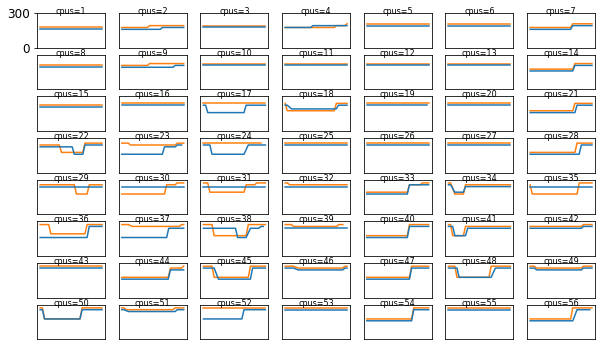

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=12)
plt.figure(figsize=(10, 6))
colors = ['tab:orange', 'tab:blue' ]

for r in range(1,9):
    for c in range(1,8):
        num = (r-1)*7+c
        #print(num)
        ax = plt.subplot(8,7,num )#figsize=(10, 6))  
        
        for idx,record_id in enumerate(record_ids):
            cdt = all_data[num-1]['data'][record_id][0]
            val = all_data[num-1]['data'][record_id][1]
            ax.plot(cdt, val, color=colors[idx])
            
        
        #ax.set_xlabel('Time')
        ax.set_ylim([0, 300])
        if num==1: ax.set_yticks([0,300])
        else: ax.set_yticks([])
        ax.set_xticks([])
        #ax.set_ylabel('Watts')
        ax.set_title('cpus=%d' % num, fontsize=8, y=0.8)
        #ax.grid(True)
#ax.legend(loc='upper left');

In [24]:
from scipy.integrate import simps
from numpy import trapz

powers = []
for i in range(len(all_data)):
    
    power = None
    for idx,record_id in enumerate(record_ids):
        cdt = all_data[i]['data'][record_id][0]
        val = all_data[i]['data'][record_id][1]
            
        tarea = trapz(val,cdt)
        sarea = simps(val,cdt)
        #print(cdt)
        #print(val)
        #print(tarea,sarea)
        #raise Exception("none")
        if not power: power = [ tarea, sarea ]
        else: power = [a + b for a, b in zip(power, [tarea, sarea])]
            
    powers.append(power)
        
print(len(powers))



56


56


(0.0, 16843.2)

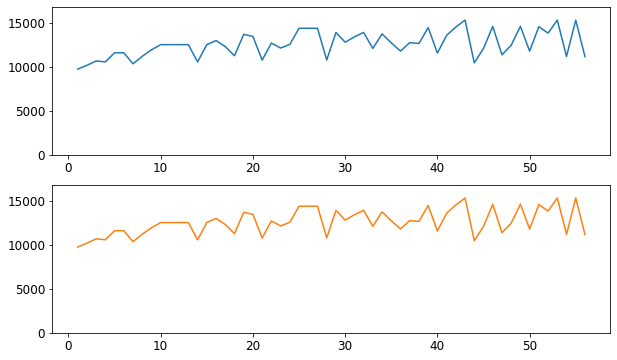

In [26]:
plt.figure(figsize=(10, 6))

print(len(all_data))
x = range(1, len(all_data)+1)
tareas = [ el[0] for el in powers]
sareas = [ el[1] for el in powers]
ax = plt.subplot(2,1,1 )
ax.plot(x, tareas, color='tab:blue')
ax.set_ylim([0, max(tareas) + 0.1*max(tareas)])
ax = plt.subplot(2,1,2 )
ax.plot(x, tareas, color='tab:orange')
ax.set_ylim([0, max(sareas) + 0.1*max(sareas)])